In [1]:
import numpy as np
from fredapi import Fred
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

# Set your FRED API key
fred = Fred(api_key='Enter Your API Key Here')

In [2]:
# Fetch data for Ohio HPI, USA HPI, Ohio Housing Permits, USA Housing Permits, Ohio Population, USA Population, 30-Year Mortgage Rate, and US Working-Age Population (25-54)
oh_hpi = fred.get_series("OHSTHPI")
us_hpi = fred.get_series("USSTHPI")
oh_permits = fred.get_series("OHBPPRIV")
us_permits = fred.get_series("PERMITNSA")
oh_population = fred.get_series("OHPOP")
us_population = fred.get_series("POPTHM")
mortgage_rate_30yr = fred.get_series("MORTGAGE30US")
us_population_25_54 = fred.get_series("LNU00000060")
us_population_65 = fred.get_series("SPPOP65UPTOZSUSA")
clevel_pop = fred.get_series("CVLPOP")
cle_hpi = fred.get_series("ATNHPIUS39035A")
us_population_20_24 = fred.get_series("LNU00000036")
cle_new_listings = fred.get_series("NEWLISCOU39035")
us_new_listings = fred.get_series("MSACSR")
cle_hotness = fred.get_series("SUSCCOUNTY39035")
debt_to_Income = fred.get_series("TDSP")
mortgage_to_Income = fred.get_series("MDSP")
Delinquency_to_Income = fred.get_series("DRSFRMACBS")
Unemployment = fred.get_series("UNRATE")
CleUnemployment = fred.get_series("OHCUYA5URN")
CleSalaries = fred.get_series("SMU39174600500000003")
Salaries = fred.get_series("BA06RC1A027NBEA")
CPI = fred.get_series("CPIAUCSL")
CCDelinq = fred.get_series("DRCCLACBS")
HousingInventory = fred.get_series("EYRVACUSQ176N")


In [3]:
# Combine all series into a single DataFrame, comment out variables you do not need.
hpi_df = pd.DataFrame({
    "Ohio HPI": oh_hpi,
    "USA HPI": us_hpi,
    "Ohio Housing Permits": oh_permits,
    #"USA Housing Permits": us_permits,
    #"Ohio Population": oh_population,
    #"USA Population": us_population,
    #"Cleveland Population" : clevel_pop,
    #"US Population (Over 65)": us_population_25_54,
    #"US Population (25-54)": us_population_65,
    #"Cleveland HPI": cle_hpi,
    #"US Population (20-24)": us_population_20_24,
    #"Cle New Listings": cle_new_listings,
    "US New Listings" : us_new_listings,
    #"30-Year Mortgage Rate": mortgage_rate_30yr,
    #"Cle Market Hotness": cle_hotness,
    #"US Debt to Income": debt_to_Income,
    "US Mortgage to Income": mortgage_to_Income,
    #"Deliquency to Income": Delinquency_to_Income,
    "Unemployment": Unemployment,
    #"Cleveland Unemployment": CleUnemployment,
    #"Cleveland Salaries": CleSalaries,
    #"Salaries": Salaries,
    #"CPI": CPI,
    "Credit Card Delinquency": CCDelinq,
    #"Housing Inventory": HousingInventory
})

#Name Dependent Variable Here
predCol = "Ohio HPI"
#Specify Periods out to forcast
forwardCols = 5
#Specify Date Aggregation
DAGG = 'Y'

In [4]:
#Adds a date column and selects the earliest value for each column for each year
dateColName = "Date"
firstCol = "First_Of"
hpi_df.index.name = dateColName  # Set the index name for clarity
hpi_df = hpi_df.reset_index()
hpi_df[firstCol] = hpi_df[dateColName].dt.to_period(DAGG).dt.start_time
hpi_df = hpi_df.groupby(firstCol).first()
hpi_df = hpi_df.reset_index().drop(columns=[firstCol])
hpi_df.to_csv("hpi_df_Group.csv")
hpi_df

,Date,Ohio HPI,USA HPI,Ohio Housing Permits,US New Listings,US Mortgage to Income,Unemployment,Credit Card Delinquency
0,1948-01-01,NaN,NaN,NaN,NaN,NaN,3.4,NaN
1,1949-01-01,NaN,NaN,NaN,NaN,NaN,4.3,NaN
2,1950-01-01,NaN,NaN,NaN,NaN,NaN,6.5,NaN
3,1951-01-01,NaN,NaN,NaN,NaN,NaN,3.7,NaN
4,1952-01-01,NaN,NaN,NaN,NaN,NaN,3.2,NaN
...,...,...,...,...,...,...,...,...
72,2020-01-01,312.38,449.73,2624.0,5.7,5.915147,3.6,2.66
73,2021-01-01,336.69,483.77,1573.0,4.1,4.784710,6.4,1.86
74,2022-01-01,392.35,578.15,2169.0,5.9,5.667339,4.0,1.67
75,2023-01-01,426.95,624.81,1150.0,8.3,5.691535,3.4,2.45


In [5]:
#Build dataframe for test and train
predCols = []
hpi_df_Source = hpi_df.set_index('Date')
hpi_df_pres = hpi_df_Source[[predCol]]
for c in range(1,forwardCols+1):
    predColNext = "Next "+ predCol + " " + str(c) + " Yr Out"
    hpi_df_Source[predColNext] = hpi_df_Source[predCol].shift(-c)
    predCols.append(predColNext) 
hpi_df_Source = hpi_df_Source.drop(columns = predCol) #Only dropping to account for when we do not have most recent data
testData = hpi_df_Source.drop(columns = predCols).dropna() #To be used for prediction
hpi_df_act = hpi_df_Source.dropna() #To be used to train
hpi_df_act

,USA HPI,Ohio Housing Permits,US New Listings,US Mortgage to Income,Unemployment,Credit Card Delinquency,Next Ohio HPI 1 Yr Out,Next Ohio HPI 2 Yr Out,Next Ohio HPI 3 Yr Out,Next Ohio HPI 4 Yr Out,Next Ohio HPI 5 Yr Out
Date,,,,,,,,,,,
1991-01-01,167.68,1933.0,9.4,6.216675,6.4,5.26,154.30,159.77,167.40,173.62,184.83
1992-01-01,172.82,2150.0,5.2,5.990278,7.3,5.27,159.77,167.40,173.62,184.83,192.27
1993-01-01,175.70,2071.0,5.4,5.773480,7.3,4.60,167.40,173.62,184.83,192.27,201.26
1994-01-01,181.42,2037.0,5.9,5.563705,6.6,3.60,173.62,184.83,192.27,201.26,210.04
1995-01-01,184.05,2154.0,6.8,5.648761,5.6,3.48,184.83,192.27,201.26,210.04,216.13
1996-01-01,193.57,2030.0,6.4,5.600129,5.6,4.04,192.27,201.26,210.04,216.13,228.54
1997-01-01,197.90,2315.0,4.7,5.619890,5.3,4.70,201.26,210.04,216.13,228.54,236.93
1998-01-01,207.94,2611.0,4.0,5.531760,4.6,4.76,210.04,216.13,228.54,236.93,244.26
1999-01-01,217.52,2314.0,3.9,5.486907,4.3,4.66,216.13,228.54,236.93,244.26,252.99


In [6]:
testData

,USA HPI,Ohio Housing Permits,US New Listings,US Mortgage to Income,Unemployment,Credit Card Delinquency
Date,,,,,,
1991-01-01,167.68,1933.0,9.4,6.216675,6.4,5.26
1992-01-01,172.82,2150.0,5.2,5.990278,7.3,5.27
1993-01-01,175.70,2071.0,5.4,5.773480,7.3,4.60
1994-01-01,181.42,2037.0,5.9,5.563705,6.6,3.60
1995-01-01,184.05,2154.0,6.8,5.648761,5.6,3.48
1996-01-01,193.57,2030.0,6.4,5.600129,5.6,4.04
1997-01-01,197.90,2315.0,4.7,5.619890,5.3,4.70
1998-01-01,207.94,2611.0,4.0,5.531760,4.6,4.76
1999-01-01,217.52,2314.0,3.9,5.486907,4.3,4.66


In [7]:
# Standardize the features (VIF can be sensitive to feature scales)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(hpi_df_act), columns=hpi_df_act.columns)
df_scaled = df_scaled.drop(columns = predCols)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

# Display the result
print(vif_data)

                   feature       VIF
0                  USA HPI  3.983638
1     Ohio Housing Permits  4.315715
2          US New Listings  3.487675
3    US Mortgage to Income  4.043844
4             Unemployment  2.475635
5  Credit Card Delinquency  3.169037


                              OLS Regression Results                              
Dep. Variable:     Next Ohio HPI 1 Yr Out   R-squared:                       0.970
Model:                                OLS   Adj. R-squared:                  0.962
Method:                     Least Squares   F-statistic:                     118.4
Date:                    Thu, 21 Nov 2024   Prob (F-statistic):           1.33e-15
Time:                            23:09:18   Log-Likelihood:                -96.691
No. Observations:                      29   AIC:                             207.4
Df Residuals:                          22   BIC:                             217.0
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

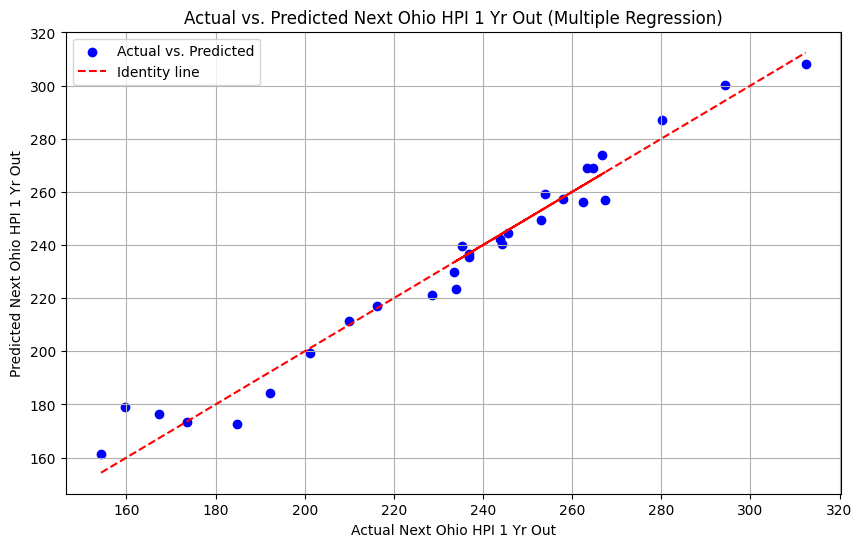

                              OLS Regression Results                              
Dep. Variable:     Next Ohio HPI 2 Yr Out   R-squared:                       0.975
Model:                                OLS   Adj. R-squared:                  0.968
Method:                     Least Squares   F-statistic:                     142.7
Date:                    Thu, 21 Nov 2024   Prob (F-statistic):           1.81e-16
Time:                            23:09:18   Log-Likelihood:                -95.057
No. Observations:                      29   AIC:                             204.1
Df Residuals:                          22   BIC:                             213.7
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

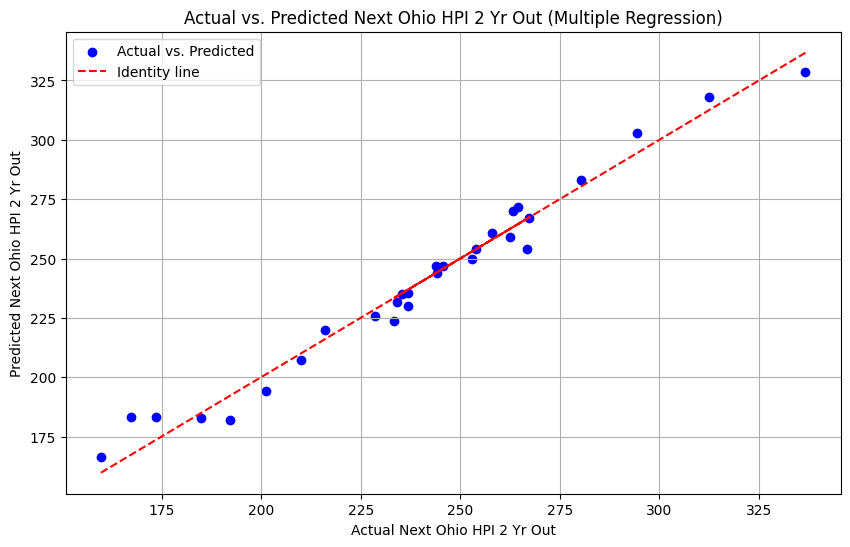

                              OLS Regression Results                              
Dep. Variable:     Next Ohio HPI 3 Yr Out   R-squared:                       0.964
Model:                                OLS   Adj. R-squared:                  0.954
Method:                     Least Squares   F-statistic:                     97.60
Date:                    Thu, 21 Nov 2024   Prob (F-statistic):           1.02e-14
Time:                            23:09:18   Log-Likelihood:                -104.36
No. Observations:                      29   AIC:                             222.7
Df Residuals:                          22   BIC:                             232.3
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

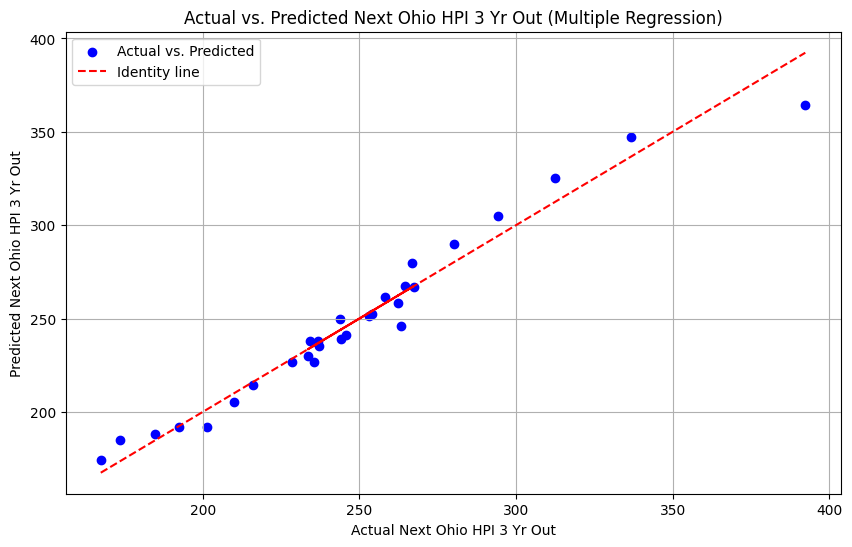

                              OLS Regression Results                              
Dep. Variable:     Next Ohio HPI 4 Yr Out   R-squared:                       0.960
Model:                                OLS   Adj. R-squared:                  0.949
Method:                     Least Squares   F-statistic:                     87.39
Date:                    Thu, 21 Nov 2024   Prob (F-statistic):           3.27e-14
Time:                            23:09:18   Log-Likelihood:                -110.47
No. Observations:                      29   AIC:                             234.9
Df Residuals:                          22   BIC:                             244.5
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

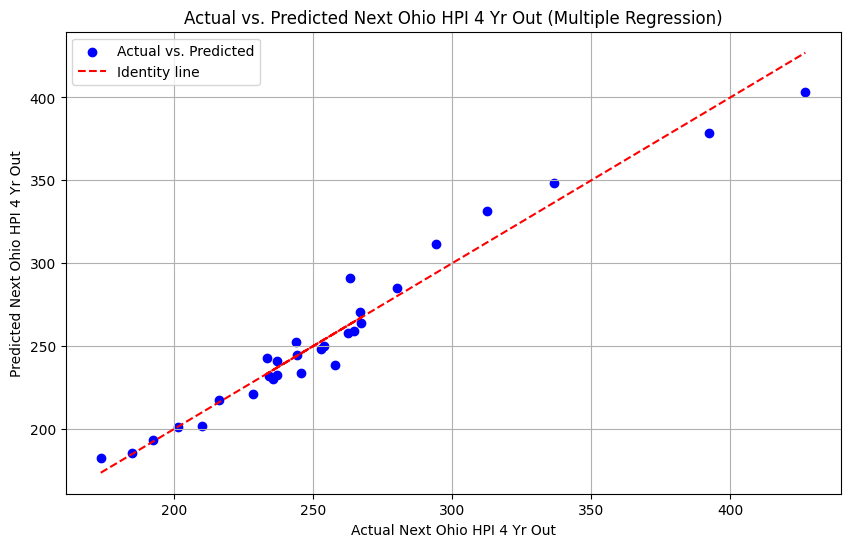

                              OLS Regression Results                              
Dep. Variable:     Next Ohio HPI 5 Yr Out   R-squared:                       0.954
Model:                                OLS   Adj. R-squared:                  0.942
Method:                     Least Squares   F-statistic:                     76.55
Date:                    Thu, 21 Nov 2024   Prob (F-statistic):           1.30e-13
Time:                            23:09:19   Log-Likelihood:                -116.86
No. Observations:                      29   AIC:                             247.7
Df Residuals:                          22   BIC:                             257.3
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

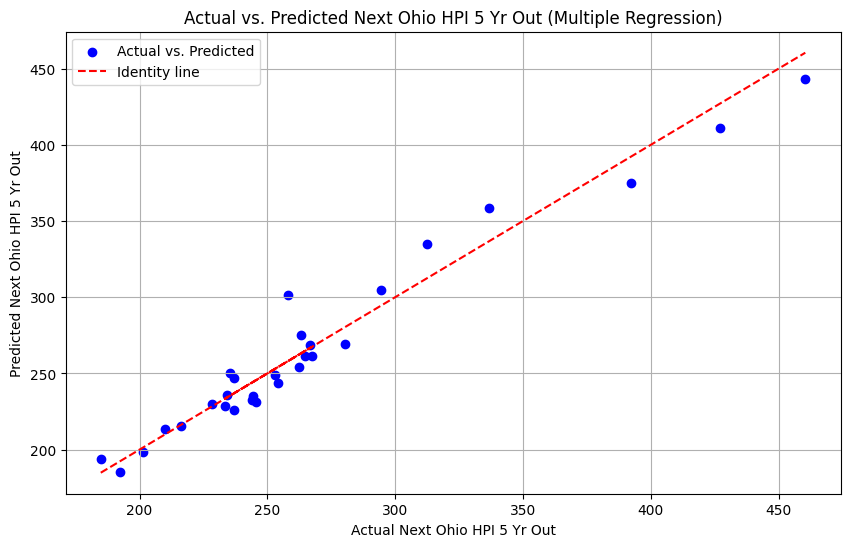

Variable,Intercept,USA HPI,Ohio Housing Permits,US New Listings,US Mortgage to Income,Unemployment,Credit Card Delinquency,Pred_Year
Coefficient,115.606974,0.592732,0.00259,-3.399269,-8.79776,-2.318464,8.141561,Next Ohio HPI 1 Yr Out
Coefficient,161.216527,0.647325,0.002741,-2.484172,-18.370953,-1.857075,7.740295,Next Ohio HPI 2 Yr Out
Coefficient,220.527883,0.75799,-0.000305,-0.079887,-33.380341,-1.622369,8.753618,Next Ohio HPI 3 Yr Out
Coefficient,289.566637,0.856387,-0.006571,2.084624,-47.116446,-2.003617,9.165697,Next Ohio HPI 4 Yr Out
Coefficient,343.773962,0.95906,-0.009085,5.694369,-60.506635,-1.169173,6.984287,Next Ohio HPI 5 Yr Out


In [8]:

def runRegression(DF,depVar,dropCols):    
    # Separate the independent variables 
    y = DF[depVar]
    X = DF.drop(columns=predCols)
    
    # Add an Intercept (if needed)
    X = sm.add_constant(X)
    
    # Fit the Multiple Regression Model
    model = sm.OLS(y, X).fit()
    
    # Step 1: Print Regression Results
    print(model.summary())
    
    # Step 2: Retrieve model parameters dynamically
    params = model.params.to_dict()  # Convert parameters to a dictionary
    intercept = params.pop('const', 0)  # Extract intercept (default to 0 if 'const' is missing)
    
    # Step 3: Calculate predicted values based on all parameters
    predicted_values = intercept
    for param_name, coefficient in params.items():
        predicted_values += coefficient * DF[param_name]
    
    # Step 4: Plot Actual vs. Predicted
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(DF[depVar], predicted_values, color='blue', label='Actual vs. Predicted')
    
    # Add a diagonal line (identity line)
    plt.plot(DF[depVar], DF[depVar], color='red', linestyle='--', label='Identity line')
    
    plt.title(f'Actual vs. Predicted {depVar} (Multiple Regression)')
    plt.xlabel(f'Actual {depVar}')
    plt.ylabel(f'Predicted {depVar}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Step 5: Create a DataFrame for the coefficients
    coefficients = pd.DataFrame({
        'Variable': ['Intercept'] + list(params.keys()),
        'Coefficient': [intercept] + list(params.values())
    }).T
    coefficients.columns = coefficients.iloc[0]  # Set the first row as the header
    coefficients = coefficients.iloc[1:]
    coefficients['Pred_Year'] = depVar
    #print(coefficients)
    return coefficients

#runRegression(hpi_df_pct_chg,'Next Ohio HPI')
coefDf = pd.DataFrame()
for thisCol in predCols:
    coefficients = runRegression(hpi_df_act,thisCol,predCols)
    coefDf = pd.concat([coefDf,coefficients])
coefDf

In [9]:
testDataNew = testData.copy()
for ind, row in coefDf.iterrows():
    testDataNew[str(row['Pred_Year'])] = row['Intercept']    
    for i, r in testData.iterrows():
        coefSum = 0
        for c, v in r.items():
            coefSum = row[c] * r[c] + coefSum 
        testDataNew.at[i,str(row['Pred_Year'])] = coefSum + testDataNew.at[i,str(row['Pred_Year'])]

testDataNew = pd.merge(testDataNew, hpi_df_pres, left_index=True, right_index=True, how='left')
testDataNew.to_csv("Predicted_" + predCol + ".csv")
testDataNew

,USA HPI,Ohio Housing Permits,US New Listings,US Mortgage to Income,Unemployment,Credit Card Delinquency,Next Ohio HPI 1 Yr Out,Next Ohio HPI 2 Yr Out,Next Ohio HPI 3 Yr Out,Next Ohio HPI 4 Yr Out,Next Ohio HPI 5 Yr Out,Ohio HPI
Date,,,,,,,,,,,,
1991-01-01,167.68,1933.0,9.4,6.216675,6.4,5.26,161.342623,166.329802,174.432865,182.539346,193.660117,147.36
1992-01-01,172.82,2150.0,5.2,5.990278,7.3,5.27,179.214740,183.250563,184.782838,185.715184,185.418067,154.30
1993-01-01,175.70,2071.0,5.4,5.773480,7.3,4.60,176.489861,183.198265,188.345854,193.191380,198.474970,159.77
1994-01-01,181.42,2037.0,5.9,5.563705,6.6,3.60,173.419518,182.979104,192.036394,201.476341,213.643773,167.40
1995-01-01,184.05,2154.0,6.8,5.648761,5.6,3.48,172.815227,182.132205,191.655033,201.732142,215.412732,173.62
1996-01-01,193.57,2030.0,6.4,5.600129,5.6,4.04,184.483751,194.176491,205.466284,217.290111,230.245500,184.83
1997-01-01,197.90,2315.0,4.7,5.619890,5.3,4.70,199.462213,207.286410,214.401666,221.300931,225.893377,192.27
1998-01-01,207.94,2611.0,4.0,5.531760,4.6,4.76,211.446039,219.719248,226.580143,232.599529,235.417143,201.26
1999-01-01,217.52,2314.0,3.9,5.486907,4.3,4.66,216.971194,225.962012,235.048893,244.344795,249.099886,210.04


In [10]:
print("Lastest 5 years " + predCol)
print(testDataNew[[predCol]][-5:])
print(predCol + " " + str(forwardCols) +  " year Housing Price Index forcast:")
testDataNew[predCols][-1:]

Lastest 5 years Ohio HPI
            Ohio HPI
Date                
2020-01-01    312.38
2021-01-01    336.69
2022-01-01    392.35
2023-01-01    426.95
2024-01-01    460.44
Ohio HPI 5 year Housing Price Index forcast:


,Next Ohio HPI 1 Yr Out,Next Ohio HPI 2 Yr Out,Next Ohio HPI 3 Yr Out,Next Ohio HPI 4 Yr Out,Next Ohio HPI 5 Yr Out
Date,,,,,
2024-01-01,452.115838,485.868738,547.68068,605.561978,669.810952


In [11]:
#Check RMSE for each forcast year
print("Evaluating Model Based on Root Mean Squared Errors:")
for c in range(1,forwardCols+1):
    predColNext = "Next "+ predCol + " " + str(c) + " Yr Out"
    RMSE = np.sqrt(((testDataNew[predCol] - testDataNew[predColNext].shift(c)) ** 2).mean())
    print("RMSE for {} year forcast {}".format(c,round(RMSE,2)))


Evaluating Model Based on Root Mean Squared Errors:
RMSE for 1 year forcast 12.73
RMSE for 2 year forcast 13.58
RMSE for 3 year forcast 12.99
RMSE for 4 year forcast 14.41
RMSE for 5 year forcast 13.61
